### Frequenncy_data_analysis

#### Import libraries

In [1]:
# Step 1: Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from sqlalchemy import text
from sqlalchemy import create_engine
import geopandas as gpd

#### Create the connection with the DB

In [2]:
# Step 1: Create the connection with the DB
engine = create_engine("postgresql://urbaninfo:@cirrus.ita.chalmers.se/se_tuptp")
conn = engine.connect()

In [3]:
# Step 2: Create a new schema when it is necessary
#schema = '''CREATE SCHEMA name_schema'''
#conn.execute(schema)

#### Import data

In [64]:
# Step 1: Import Data
# In this example, we are utilizing data from Västra Götaland, although these can be modified based on specific requirements.
# Links_model_0
links_pt_0_query = text('''SELECT * FROM pt_0_baseline.links_pt_0''')
links_pt_0 = gpd.read_postgis(links_pt_0_query, engine, geom_col='geometry')

# Calendar_dates GTFS
calendar_dates_gtfs_query = text('''SELECT * FROM p1_gtfs.regional_calendardates''')
calendar_dates_gtfs = pd.read_sql(calendar_dates_gtfs_query, engine)

#### Frequency Data Analysis

In [65]:
# Preprocess the calendar_dates data
# Step 1: Adjust the date format on the calendar_dates
calendar_dates_gtfs['date'] = pd.to_datetime(calendar_dates_gtfs['date'], format='%Y%m%d')

# Step 2: Create a column with the day of the week
calendar_dates_gtfs['day_week'] = calendar_dates_gtfs['date'].dt.day_name()

# Step 3: Create a column with the day type
day_type_dic = {
    'Monday': 'week_day',
    'Tuesday': 'week_day',
    'Wednesday': 'week_day',
    'Thursday': 'week_day',
    'Friday': 'week_day',
    'Saturday': 'weekend',
    'Sunday': 'weekend'
}
# Step 4: Create a day_type column based on the type of the day_week
calendar_dates_gtfs['day_type'] = calendar_dates_gtfs['day_week'].map(day_type_dic)

# Step 5: Create the week_start and the week_number columns based on the date
calendar_dates_gtfs['week_start'] = calendar_dates_gtfs['date'].dt.to_period('W').apply(lambda r: r.start_time)
calendar_dates_gtfs['week_number'] = calendar_dates_gtfs['week_start'].dt.isocalendar().week.astype(int)

# Step 6 (optional): Display the results
calendar_dates_gtfs.head()

,service_id,date,exception_type,day_week,day_type,week_start,week_number
0,1,2022-08-15,1,Monday,week_day,2022-08-15,33
1,1,2022-08-16,1,Tuesday,week_day,2022-08-15,33
2,1,2022-08-17,1,Wednesday,week_day,2022-08-15,33
3,1,2022-08-18,1,Thursday,week_day,2022-08-15,33
4,1,2022-08-19,1,Friday,week_day,2022-08-15,33


In [66]:
# Step 7: Merge the links of the baseline model with the modified calendar_dates droping duplicates trips by time period and date
links_calendar_merge = pd.merge (links_pt_0, calendar_dates_gtfs,
                                 on='service_id', how='inner').drop_duplicates(subset=['trip_id', 'time_period','date'])

# Step 8 (optional): Display the results
links_calendar_merge.head()

,source,target,route_short_name,mode,time_distance,time_period,route_id,service_id,trip_id,direction_id,...,stop_name_target,place_id_source,place_id_target,geometry,date,exception_type,day_week,day_type,week_start,week_number
0,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,145235353,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-07-31,1,Sunday,weekend,2022-07-25,30
1,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,145235353,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-06,1,Saturday,weekend,2022-08-01,31
2,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,145235353,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-07,1,Sunday,weekend,2022-08-01,31
3,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,145235353,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-13,1,Saturday,weekend,2022-08-08,32
4,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,145235353,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-14,1,Sunday,weekend,2022-08-08,32


#### create the graphs to verify trip profiles

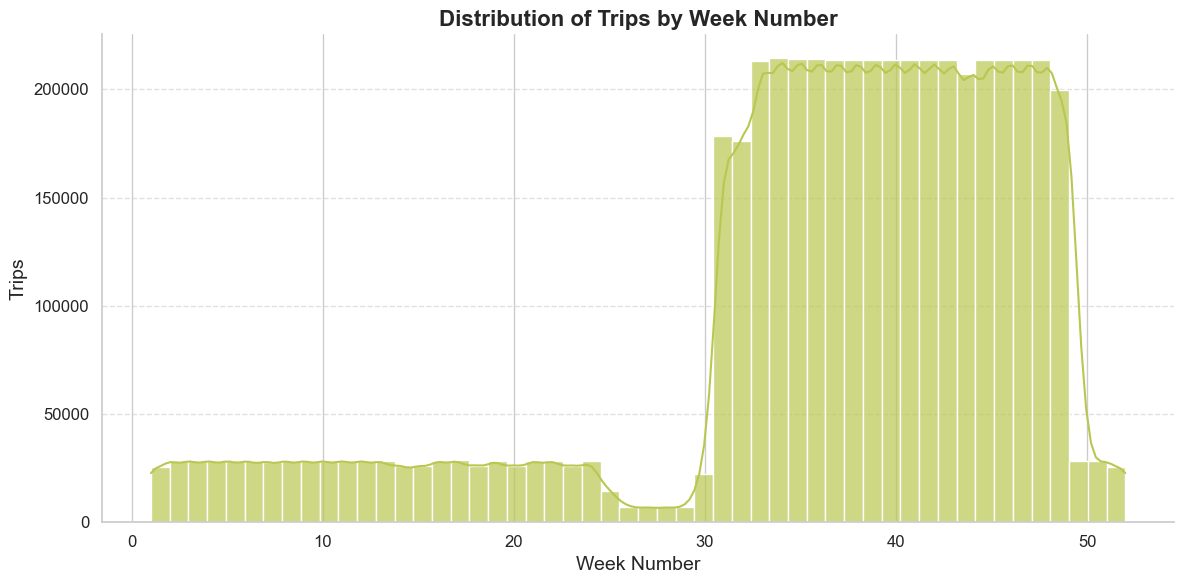

In [7]:
# Create the graphs to verify trip profiles
# Step 9: Verify the distribution of trips by week number
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=links_calendar_merge, x='week_number', bins=52, color='#B9C750', alpha=0.7, ax=ax, kde=True)
ax.set_title('Distribution of Trips by Week Number', fontsize=16, fontweight='bold')
ax.set_xlabel('Week Number', fontsize=14)
ax.set_ylabel('Trips', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 10: Display the results
plt.show()

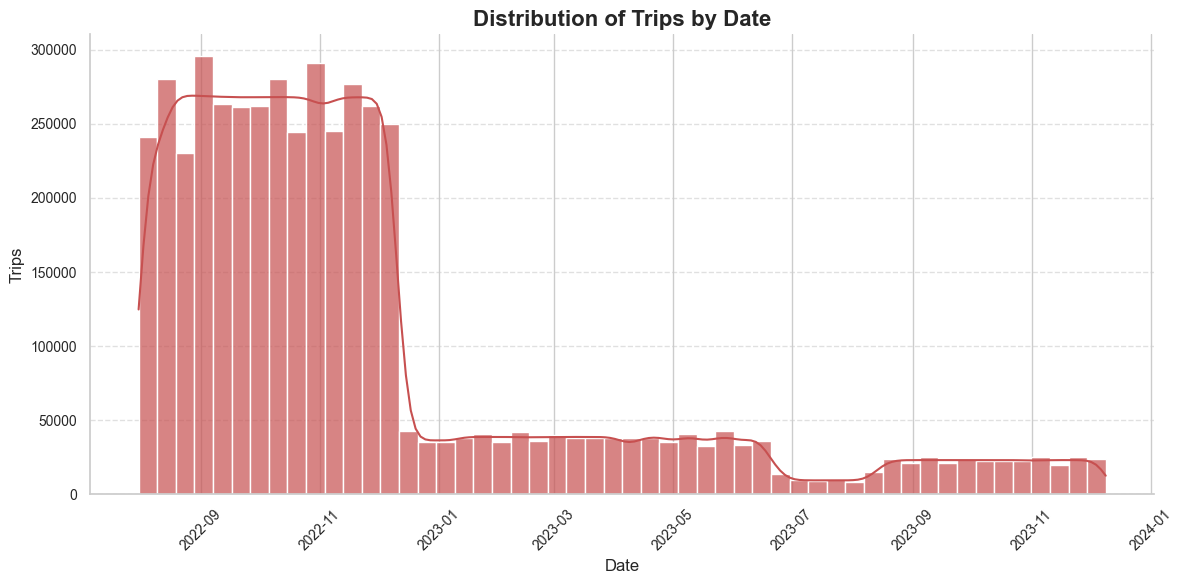

In [8]:
# Step 11: Verify the distribution of trips by date
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=links_calendar_merge, x='date', bins=52, color='#C75050', alpha=0.7, ax=ax, kde=True)
ax.set_title('Distribution of Trips by Date', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Step 12: Display the results
plt.show()

#### filter the DataFrame based on trip concentration

In [67]:
# Step 13: Filter the DataFrame based on trip concentration by date
links_calendar_filtered = links_calendar_merge[
    links_calendar_merge['date'].between('2022-09-01', '2022-12-10')
]

# Step 14: Create a week_count column based on route_id and service_id
links_calendar_filtered['week_count'] = links_calendar_filtered.groupby(['route_id', 'service_id'])['week_number'].transform('nunique')

# Step 15: Create a service_count column based on week_count
links_calendar_filtered['service_count'] = links_calendar_filtered.groupby(['week_count'])['service_id'].transform('nunique')

# Step 16: Display the results
links_calendar_filtered.head()

C:\Users\monaliza\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\monaliza\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,source,target,route_short_name,mode,time_distance,time_period,route_id,service_id,trip_id,direction_id,...,place_id_target,geometry,date,exception_type,day_week,day_type,week_start,week_number,week_count,service_count
9,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-03,1,Saturday,weekend,2022-08-29,35,15,244
10,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-04,1,Sunday,weekend,2022-08-29,35,15,244
11,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-10,1,Saturday,weekend,2022-09-05,36,15,244
12,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-11,1,Sunday,weekend,2022-09-05,36,15,244
13,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,145235353,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-17,1,Saturday,weekend,2022-09-12,37,15,244


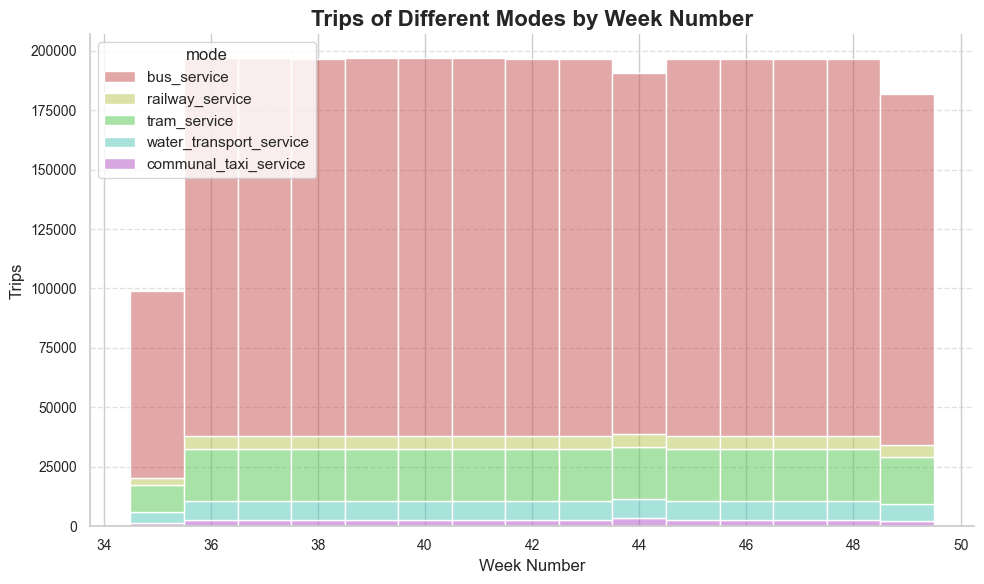

In [10]:
# Step 17a: Verify the distributions of trips of different modes by week number
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=links_calendar_filtered, x='week_number', discrete=True, alpha=0.5, bins=52,
    hue='mode', element='bars', multiple='stack', palette= ['#C75050', '#B9C750', '#52C750', '#50C7B9', '#B350C7'], hue_order=['bus_service', 'railway_service', 'tram_service', 'water_transport_service', 'communal_taxi_service'], legend=True
)
ax.set_title('Trips of Different Modes by Week Number', fontsize=16, fontweight='bold')
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 18a: Display the results
plt.show()

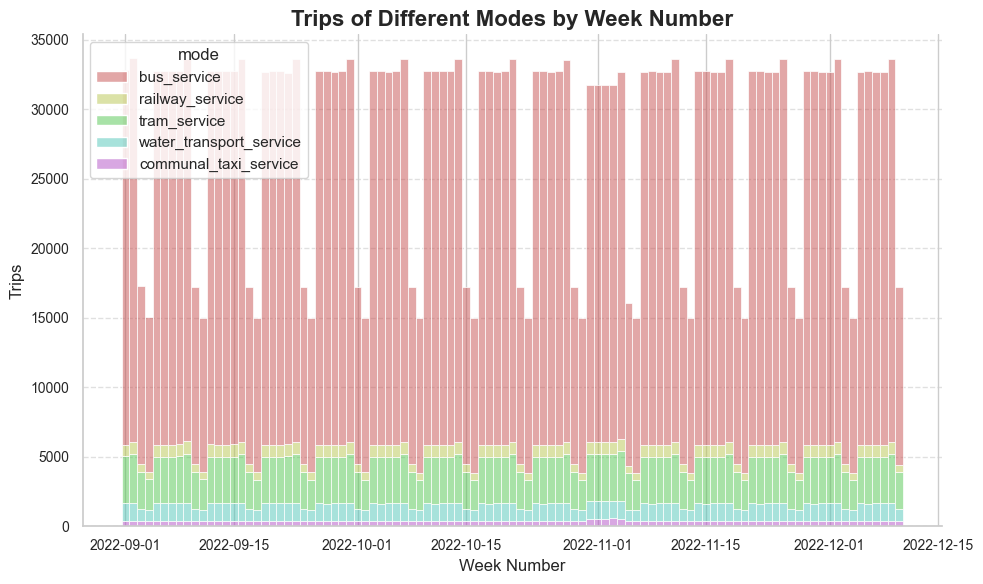

In [11]:
# Step 17b: Verify the distributions of trips of different modes by week number
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=links_calendar_filtered, x='date', discrete=True, alpha=0.5, bins=52,
    hue='mode', element='bars', multiple='stack', palette= ['#C75050', '#B9C750', '#52C750', '#50C7B9', '#B350C7'], hue_order=['bus_service', 'railway_service', 'tram_service', 'water_transport_service', 'communal_taxi_service'], legend=True
)
ax.set_title('Trips of Different Modes by Week Number', fontsize=16, fontweight='bold')
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 18b: Display the results
plt.show()

C:\Users\monaliza\AppData\Local\Temp\ipykernel_14024\1720331367.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


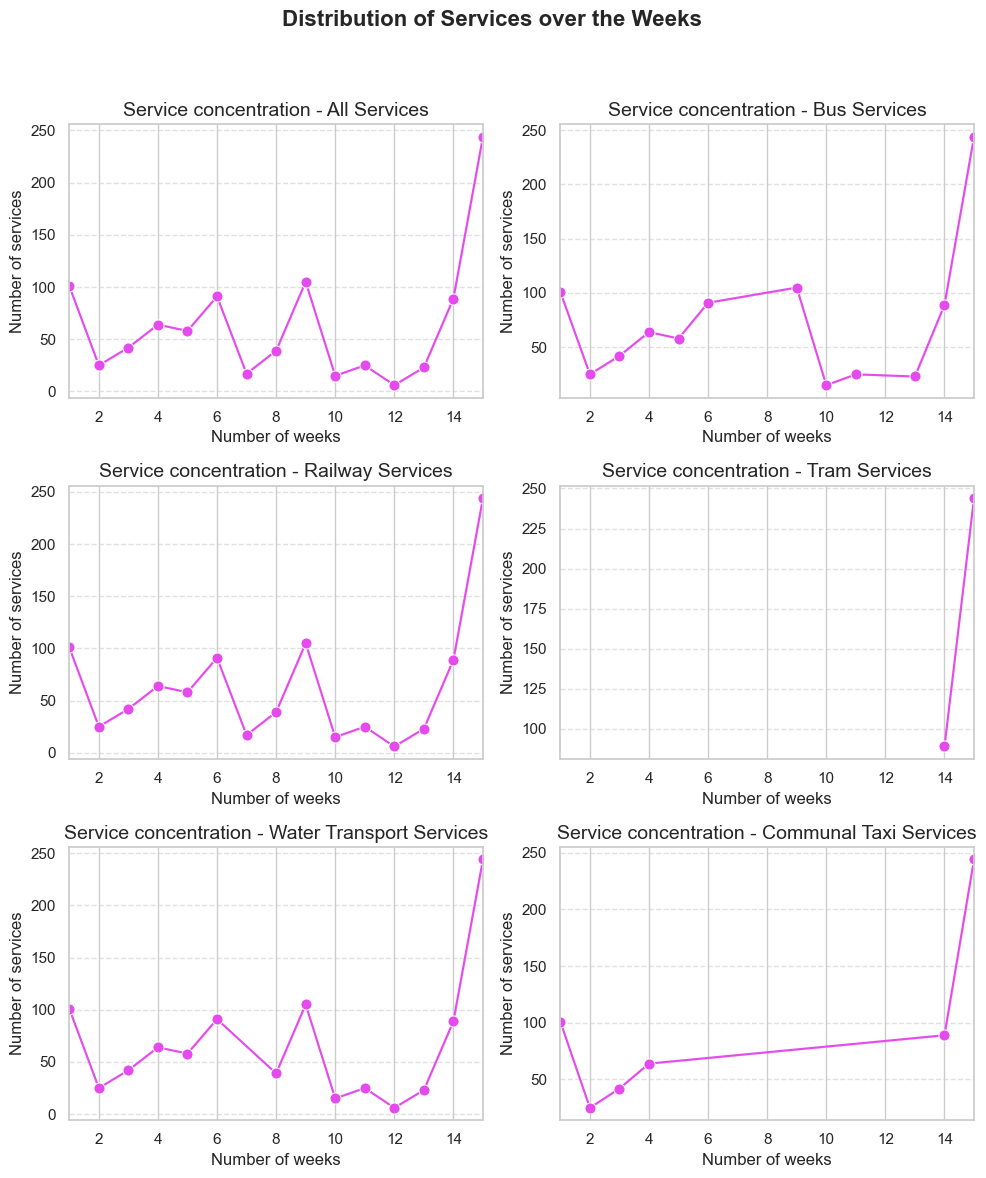

In [34]:
# Step 19: Verify the concentration of services over the week
# This step is essential to verify the regularity of operation for each service, and consequently, the regularity of operation for the entire public transport system.
fig, axes = plt.subplots(3, 2, figsize=(10, 12), constrained_layout=True)
service_modes = ['All Services', 'Bus Services', 'Railway Services', 'Tram Services', 'Water Transport Services', 'Communal Taxi Services']

x_min = links_calendar_filtered['week_count'].min()
x_max = links_calendar_filtered['week_count'].max()

for i, mode in enumerate(service_modes):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    if mode == 'All Services':
        data = links_calendar_filtered
    elif mode == 'Bus Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'bus_service']
    elif mode == 'Railway Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'railway_service']
    elif mode == 'Tram Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'tram_service']
    elif mode == 'Water Transport Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'water_transport_service']
    elif mode == 'Communal Taxi Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'communal_taxi_service']

    g = sns.lineplot(data=data, x='week_count', y='service_count', color='#E54AED', marker='o', markersize=8, ax=ax)
    g.set_xlim(x_min, x_max)
    g.set_title(f'Service concentration - {mode}', fontsize=14)
    g.set_xlabel('Number of weeks', fontsize=12)
    g.set_ylabel('Number of services', fontsize=12)
    g.yaxis.grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Distribution of Services over the Weeks', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Step 20: Display the results
plt.show()

In [76]:
#Exlplore the routes by week
links_calendar_filtered.loc [:,'unique_route_count'] = links_calendar_filtered.groupby('week_count')['route_id'].transform('nunique')

links_calendar_filtered.head()

,source,target,route_short_name,mode,time_distance,time_period,route_id,service_id,trip_id,direction_id,...,geometry,date,exception_type,day_week,day_type,week_start,week_number,week_count,service_count,unique_route_count
9,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-03,1,Saturday,weekend,2022-08-29,35,15,244,568
10,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-04,1,Sunday,weekend,2022-08-29,35,15,244,568
11,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-10,1,Saturday,weekend,2022-09-05,36,15,244,568
12,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-11,1,Sunday,weekend,2022-09-05,36,15,244,568
13,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-17,1,Saturday,weekend,2022-09-12,37,15,244,568


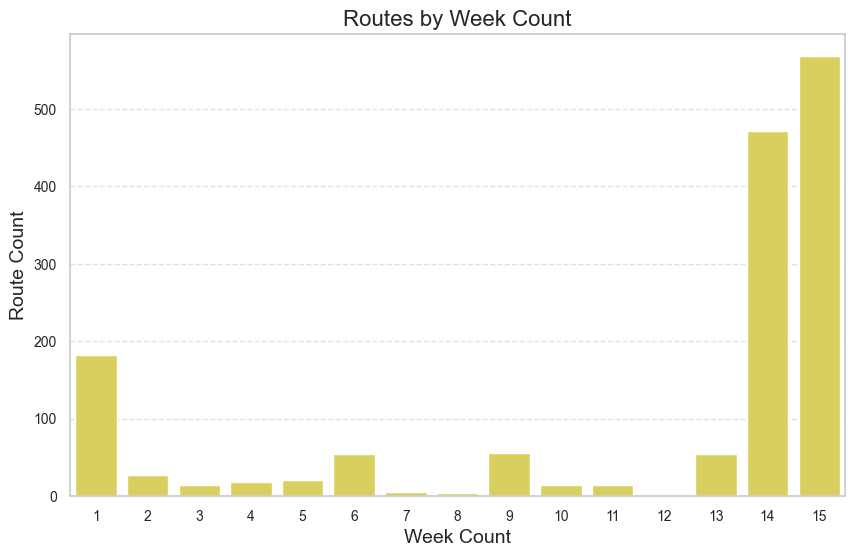

In [77]:
# Step 24: Visualize the number of routes operation
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(links_calendar_filtered, x= 'week_count', y='unique_route_count', color='#EDE04A')
plt.xlabel('Week Count', fontsize=14)
plt.ylabel('Route Count', fontsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='both', labelsize=10)
plt.title('Routes by Week Count', fontsize=16)
plt.show()

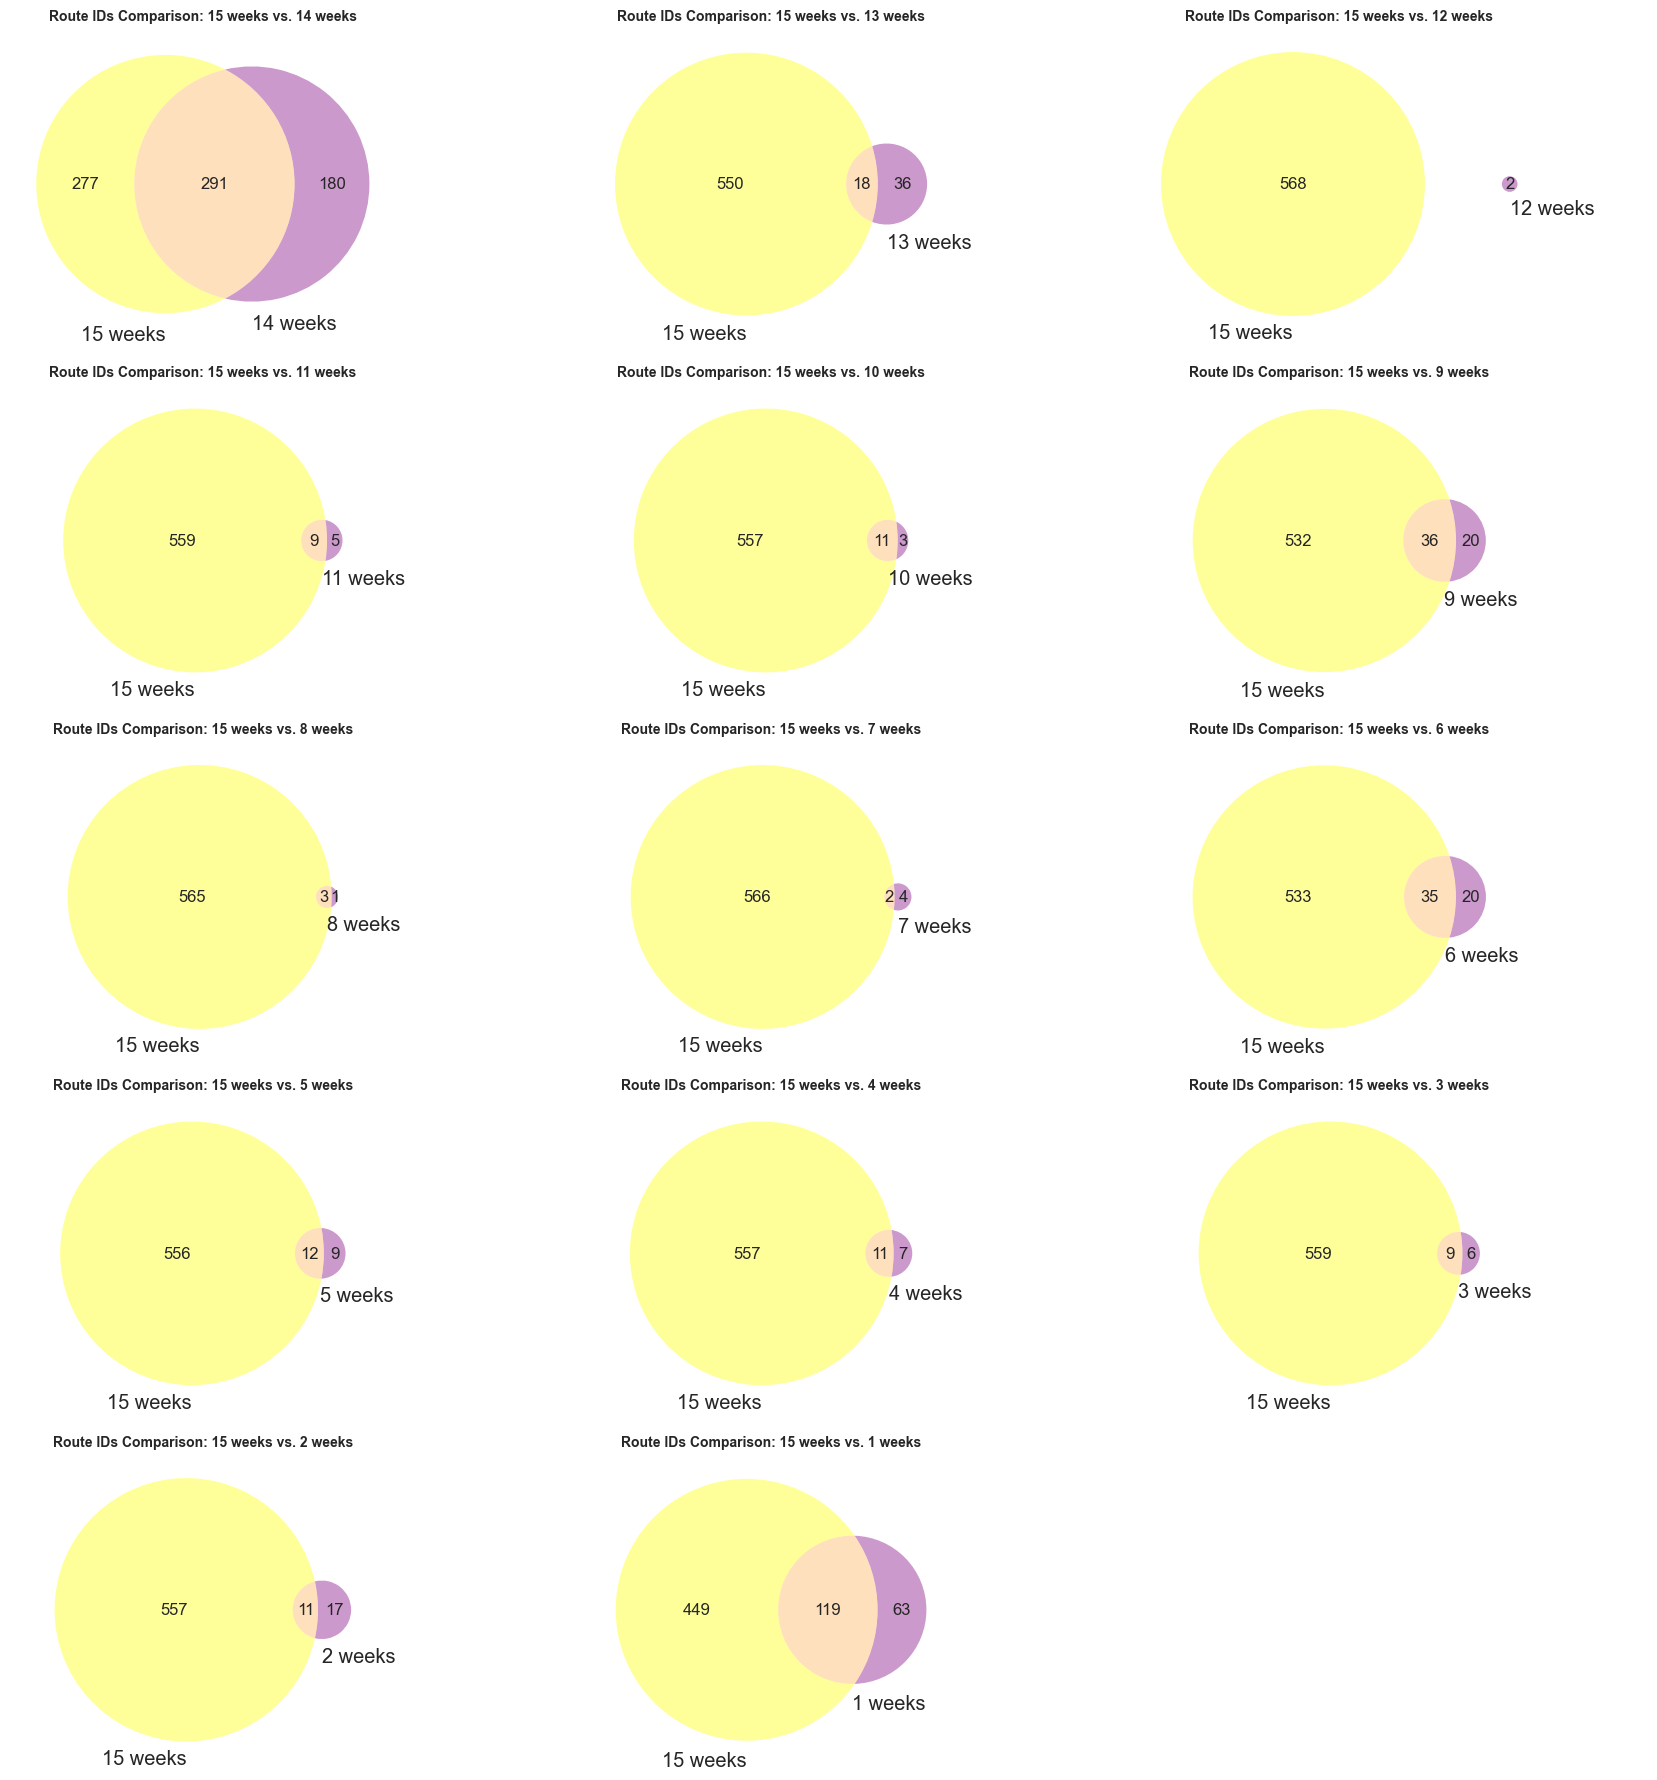

In [87]:
# Visualize overlaping over the weeks
fig, axs = plt.subplots(5, 3, figsize=(18, 18))

for i in range(14, 0, -1):
    row = (14 - i) // 3
    col = (14 - i) % 3
    axs[row, col].set_title(f'Route IDs Comparison: 15 weeks vs. {i} weeks', fontsize=10, fontweight='bold')
    venn2([set(links_calendar_filtered[links_calendar_filtered['week_count'] == 15]['route_id']),
           set(links_calendar_filtered[links_calendar_filtered['week_count'] == i]['route_id'])],
          set_labels=('15 weeks', f'{i} weeks'), set_colors=("yellow", "purple"), ax=axs[row, col])
    axs[4, 2].axis('off')

plt.tight_layout()
plt.show()

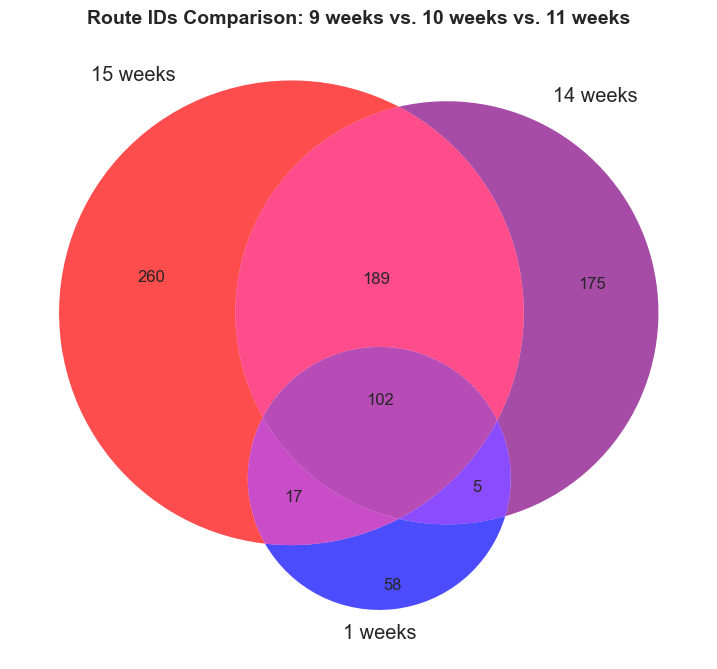

In [75]:
# Step 28: Visualize the overlapings of routes
fig, ax = plt.subplots(figsize=(9, 9))

venn3([set(links_calendar_filtered[links_calendar_filtered['week_count'] == 15]['route_id']),
       set(links_calendar_filtered[links_calendar_filtered['week_count'] == 14]['route_id']),
       set(links_calendar_filtered[links_calendar_filtered['week_count'] == 1]['route_id'])],
      set_labels=('15 weeks', '14 weeks', '1 week'),
      set_colors=('red', 'purple', 'blue'),
      alpha=0.7,
      ax=ax)

ax.set_title('Route IDs Comparison: 9 weeks vs. 10 weeks vs. 11 weeks', fontsize=14, fontweight='bold')
plt.show()